In [1]:
import numpy as np
###list of data files
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
import math
from itertools import groupby
from operator import itemgetter
import more_itertools as mit
import time
from numpy import array
from numpy.random import rand
import datetime

In [2]:
def check_outlier(x):
    if x > 0.2 or x < -0.2:
        return "True"
    else:
        return "False"

In [3]:
def transfer_to_list_of_pd(clusters_list):
    clusters_data_list = []
    for i in clusters_list:
        temp_data = pd.DataFrame(i, columns =['SecurityID', 'Sector', 'Industry','Sub_Industry','Seniority','Issuedby','Country','Rating','AmountIssued','Coupon','IssueDate','MaturityDate'])
        clusters_data_list.append(temp_data)
    return clusters_data_list

In [4]:
def assign_rating(x):
    x = float(x)
    if x < 0:
        return 'NR'
    elif x >0 and x<=0.5:
        return 'D'
    elif x > 0.5 and x<=1.5:
        return 'C'
    elif x > 1.5 and x<=2.5:
        return 'CC-'
    elif x > 2.5 and x<=3.5:
        return 'CC'
    elif x >3.5 and x<=4.5:
        return 'CC+'
    elif x >4.5 and x <=5.5:
        return 'CCC-'
    elif x >5.5 and x <=6.5:
        return 'CCC'
    elif x >6.5 and x<=7.5:
        return 'CCC+'
    elif x >7.5 and x <= 8.5:
        return 'B-'
    elif x>8.5 and x <=9.5:
        return 'B'
    elif x> 9.5 and x <= 10.5:
        return 'B+'
    elif x >10.5 and x<=11.5:
        return 'BB-'
    elif x > 11.5 and x<=12.5:
        return 'BB'
    elif x >12.5 and x<=13.5:
        return 'BB+'
    elif x>13.5 and x <=14.5:
        return 'BBB-'
    elif x>14.5 and x<=15.5:
        return 'BBB'
    elif x>15.5 and x<=16.5:
        return 'BBB+'
    elif x>16.5 and x<=17.5:
        return 'A-'
    elif x > 17.5 and x<=18.5:
        return 'A'
    elif x >18.5 and x<=19.5:
        return 'A+'
    elif x>19.5 and x<=20.5:
        return 'AA-'
    elif x >20.5 and x<=21.5:
        return 'AA'
    elif x>21.5 and x<=22.5:
        return 'AA+'
    else:
        return 'AAA'

In [5]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

In [6]:
def grab_clusters(clusters,bond_spread_list,security_data,rating_data):
    temp_list = []
    for cluster in clusters:
        temp_list2 = []
        for bond_index in cluster:
            bond_id = bond_spread_list[bond_index][1]
            bond_Sector = security_data[security_data['SecurityID']==bond_id].SecuritySector.iloc[0]
            bond_Industry = security_data[security_data['SecurityID'] == bond_id].SecurityIndustry.iloc[0]
            bond_sub_Industry = security_data[security_data['SecurityID'] == bond_id].SecuritySubIndustry.iloc[0]
            bond_Seniority = security_data[security_data['SecurityID'] == bond_id].Seniority.iloc[0]
            bond_Issuer =security_data[security_data['SecurityID'] == bond_id].Issuer.iloc[0]
            bond_countryrisk =security_data[security_data['SecurityID'] == bond_id].CountryRisk.iloc[0]
            bond_amountIssued =security_data[security_data['SecurityID'] == bond_id].AmountIssued.iloc[0]
            bond_coupon =security_data[security_data['SecurityID'] == bond_id].Coupon.iloc[0]
            bond_MaturityDate =security_data[security_data['SecurityID'] == bond_id].MaturityDate.iloc[0]
            bond_issuedate =security_data[security_data['SecurityID'] == bond_id].IssueDate.iloc[0][:4]
            try:
                bond_rating=rating_data[rating_data['SecurityID'] == bond_id].RatingSP.iloc[0]
            except:
                bond_rating = 'Not Founded'
            temp_tuple = (bond_id,bond_Sector,bond_Industry,bond_sub_Industry,bond_Seniority,bond_Issuer,bond_countryrisk,bond_rating,bond_amountIssued,bond_coupon,bond_issuedate,bond_MaturityDate)
            temp_list2.append(temp_tuple)
        temp_list.append(temp_list2)
    return temp_list

In [7]:
def merge_left_right(data1,data2):
    temp_data = data1.append(data2)
    return temp_data

def merg_sort(list_data):
    list_length = len(list_data)
    if list_length == 1:
        output = list_data[0][2]
        return output
    else:
        mid_point = math.floor(list_length/2)
        #print(len(list_data[:mid_point]))
        left = list_data[mid_point:]
        right = list_data[:mid_point]
        return merge_left_right(merg_sort(left), merg_sort(right))

In [8]:
def sliding_windows(data,period_of_time,start_date):
    #transfer start_date to datetime()
    time_list = start_date.split('-')
    year = int(time_list[0])
    month = int(time_list[1])
    date = int(time_list[2])
    start_datetime = datetime.datetime(year, month, date)
    data['KeyDate'] = pd.to_datetime(data['KeyDate'])
    data['MaturityDate'] = pd.to_datetime(data['MaturityDate'])
    data['IssueDate'] = pd.to_datetime(data['IssueDate'])
    ###find the end date:
    end_datetime = start_datetime + datetime.timedelta(days=period_of_time)
    end_date = str(end_datetime.date())
    #####select data before the end_date
    data = data[data['KeyDate'] <= end_date]
    data = data[data['IssueDate'] <= start_datetime]
    data = data[data['MaturityDate'] >= end_date]
    return data

In [9]:
def apply_fill(data_list,index):
    for i in data_list:
        try:
            fill_the_GSpeard(i)
        except:
            index.append(i)
    return index,data_list

In [10]:
def merge_data(lists,initial_data):
    data = initial_data
    for file in lists:
        #path = 'C:\\Users\\y437l\\OneDrive\\MMAI\\Capstone\\Data\\{}'.format(file)
        path = '/Users/yangli/OneDrive/MMAI/Capstone/Data/{}'.format(file)
        temp_data = pd.read_csv(path)
        print(len(temp_data))
        data = data.append(temp_data)
        print(len(data))
    return data

In [11]:
start_time = time.time()
#security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = security_data[['SecurityID','Currency','IssueDate','MaturityDate']]
### merge spread data togther
sc = MinMaxScaler()
#data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/1.csv")
data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/1.csv")
file_lists = ['14426.csv','24001.csv','36128.csv','48087.csv','55086.csv']
final_data = merge_data(file_lists,data)
#final_data = data
###left join the currency data into the spread data
final_data = final_data.merge(security_data, on=['SecurityID'], how='left')
final_data.dropna(subset=["ZSpread"],inplace=True)
###select currency as USD
final_data_1 = final_data[final_data.Currency == 'USD']
final_data = final_data_1.groupby('SecurityID')
###create a list of bond with data
bonds_list = [final_data.get_group(x) for x in final_data.groups]

1054948
2103331
961878
3065209
1074473
4139682
869630
5009312
584171
5593483


In [12]:
final_data2 = merge_data(file_lists,data)

1054948
2103331
961878
3065209
1074473
4139682
869630
5009312
584171
5593483


In [13]:
#security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
security_data[security_data.SecurityID == 39321]

SecurityID         OfficialName SecurityType SecuritySubType  \
15287       39321  CACC 6.125 02/15/21         Bond            Bond   

      SecurityBBGType SecurityBBGYellowKey Series SecuritySector  \
15287          GLOBAL                 Corp    NaN     Financials   

       SecurityIndustry SecuritySubIndustry  ...     Seniority   PaymentRank  \
15287  Consumer Finance  Finance-Auto Loans  ...  Sr Unsecured  Sr Unsecured   

      IsBailIn QuoteSize AmountIssued MinIncrement  MinPiece BBGDescription  \
15287        N       100  300000000.0       1000.0    2000.0            NaN   

                 CallSchedule AdditionalData  
15287  [[2017-02-15T00:00:00"       103.063]  

[1 rows x 50 columns]

In [14]:
def fill_the_GSpeard(data):
    ##calucate the spread between gspread and z spread if the gspread is not 0.
    data['Spread_G_Z'] = data.GSpread - data.ZSpread
    ###find the nan data's index in the data:
    index_with_indicator = data.GSpread.isna()
    index_with_indicator = index_with_indicator.tolist()
    index_list = []
    for indx in range(0,len(index_with_indicator)):
        if index_with_indicator[indx] == True:
            index_list.append(indx)
    #print(index_list)
    ##find concustive missing value:
    ##example:[(22, 39), 303, (326, 343), 607]
    star_end_dates = find_ranges(index_list)
    missing_date_dict={}
    for periods in star_end_dates:
        if type(periods) !=tuple:
            missing_date_dict[str(periods)] = spread_slope(data,periods)
            value = data.Spread_G_Z.iloc[periods-1]+missing_date_dict[str(periods)][3]
            print(value)
            data.GSpread.iloc[periods] = data.ZSpread.iloc[periods]+value
            print(data.GSpread.iloc[periods])
        else:
            missing_date_dict['{}-{}'.format(periods[0],periods[1])] = spread_slope(data, periods)
            star = missing_date_dict['{}-{}'.format(periods[0],periods[1])][0]
            end = missing_date_dict['{}-{}'.format(periods[0],periods[1])][1]
            slope = missing_date_dict['{}-{}'.format(periods[0],periods[1])][3]
            for days in range(star+1,end):
                value = data.Spread_G_Z.iloc[star] + (days-star)*slope
                data.GSpread.iloc[days] = data.ZSpread.iloc[days]+value
    print(missing_date_dict)
    #if missing_date_dict['{}-{}'.format(periods[0],periods[1])][3] >=1:
        #print(missing_date_dict)
        #print("Warning {}".format(data.SecurityID.iloc[0]))
    return data

In [15]:
def find_ranges(iterable):
    """Yield range of consecutive numbers."""
    for group in mit.consecutive_groups(iterable):
        group = list(group)
        if len(group) == 1:
            yield group[0]
        else:
            yield group[0], group[-1]

In [16]:
def spread_slope(data,input):
    if type(input) != tuple:
        star = input-1
        end = input+1
    else:
        star = input[0] - 1
        end = input[1] + 1
    if end == len(data):
        slope = data.Spread_G_Z.iloc[star]
        end = 'None'
        gap = 1
    else:
        print(input)
        star_point = data.Spread_G_Z.iloc[star]
        print(star_point)
        end_point = data.Spread_G_Z.iloc[end]
        print(end_point)
        gap = (end-star)
        print(gap)
        slope = (end_point - star_point) / gap
        print(slope)
    return (star, end, gap,slope)

In [17]:
def select_data(num,listoftuble):
    temp_list = []
    for i in listoftuble:
        if i[0] == num:
            temp_list.append(i)
    return temp_list

## Select the data with only spread percentage change.
def select_spread_data(listoftuble):
    temp_list = []
    for i in listoftuble:
        temp_list.append(i[2])
    return temp_list

In [18]:
problemtic_data_index =[]
problem_data_index,bonds_list = apply_fill(bonds_list,problemtic_data_index)
print("--- %s seconds ---" % (time.time() - start_time),'Next Step:Percentage Changed')

0001
-1.9551934999999787
452.98280650000004
78
-1.6455179999999245
-3.3275160000000596
2
-0.8409990000000676
-2.486516999999992
459.559483
{'70': (69, 71, 2, -1.622106500000001), '78': (77, 79, 2, -0.8409990000000676)}
{}
{}
35
-6.992733000000044
-9.745722999999998
2
-1.3764949999999772
-8.369228000000021
278.55177199999997
{'35': (34, 36, 2, -1.3764949999999772)}
58
-11.362067999999994
-14.605354000000005
2
-1.621643000000006
-12.983711
194.527289
{'58': (57, 59, 2, -1.621643000000006)}
58
-6.080476000000004
-9.531576000000001
2
-1.7255499999999984
-7.806026000000003
202.462974
66
-6.853035000000034
-8.256179000000003
2
-0.7015719999999845
-7.5546070000000185
212.96239299999996
{'58': (57, 59, 2, -1.7255499999999984), '66': (65, 67, 2, -0.7015719999999845)}
51
-12.987908000000004
-13.714681000000013
2
-0.3633865000000043
-13.351294500000009
205.3507055
{'51': (50, 52, 2, -0.3633865000000043)}
71
-5.563229999999976
-8.028028999999947
2
-1.2323994999999854
-6.795629499999961
508.3113705

In [19]:
bond_spread_list = []
for bond in bonds_list:
    try:
        bond['G_change']=bond.GSpread.pct_change()
        bond.dropna(subset=['G_change'],inplace = True)
        bond['outlier'] = bond.G_change.apply(check_outlier)
        bond = sliding_windows(bond, 60, '2019-01-02')
        if "True" not in bond['outlier'].values:
            bond_spread_list.append((len(bond.GSpread.values),bond.SecurityID.iloc[0],bond))
    except:
        pass

In [20]:
bond_spread_list[1][2]

SecurityID    KeyDate    Price  YieldWorst  ModifiedDuration_Plain  \
345          72 2019-01-02  101.317     5.75793                 3.83258   
346          72 2019-01-03  101.682     5.66342                 3.82767   
347          72 2019-01-04  101.332     5.75317                 3.82244   
348          72 2019-01-07  101.562     5.69385                 3.82162   
349          72 2019-01-08  101.679     5.66345                 3.81995   
350          72 2019-01-09  101.924     5.60031                 3.81924   
351          72 2019-01-10  102.065     5.56341                 3.81261   
352          72 2019-01-11  102.886     5.35399                 3.81620   
353          72 2019-01-14  102.949     5.33739                 3.81411   
354          72 2019-01-15  103.307     5.24635                 3.81422   
355          72 2019-01-16  103.844     5.11061                 3.81563   
356          72 2019-01-17  103.835     5.11066                 3.80530   
357          72 2019-01-18  103.945     5.08231                 3.80355   
358          72 2019-01-22  104.203     5.01702                 3.80288   
359          72 2019-01-23  104.137     5.03280                 3.79984   
360          72 2019-01-24  104.406     4.96352                 3.79411   
361          72 2019-01-25  104.114     5.03615                 3.78940   
362          72 2019-01-28  104.001     5.06417                 3.78600   
363          72 2019-01-29  104.377     4.96520                 3.78902   
364          72 2019-01-30  104.223     5.00740                 3.78508   
365          72 2019-01-31  104.665     4.89444                 3.78062   
366          72 2019-02-01  104.160     5.02087                 3.77434   
367          72 2019-02-04  104.136     5.02623                 3.77160   
368          72 2019-02-05  104.129     5.02736                 3.76899   
369          72 2019-02-06  104.041     5.04907                 3.76577   
370          72 2019-02-07  103.927     5.07611                 3.75724   
371          72 2019-02-08  103.754     5.11956                 3.75339   
372          72 2019-02-11  103.557     5.16942                 3.74937   
373          72 2019-02-12  103.554     5.16959                 3.74678   
374          72 2019-02-13  103.466     5.19152                 3.74356   
375          72 2019-02-14  103.578     5.16081                 3.73413   
376          72 2019-02-15  103.666     5.13759                 3.73222   
377          72 2019-02-19  103.905     5.07589                 3.73141   
378          72 2019-02-20  104.355     4.96049                 3.73216   
379          72 2019-02-21  104.244     4.98698                 3.72364   
380          72 2019-02-22  104.469     4.92901                 3.72272   
381          72 2019-02-25  104.505     4.91895                 3.72043   
382          72 2019-02-26  104.795     4.84451                 3.71998   
383          72 2019-02-27  104.959     4.80062                 3.71348   
384          72 2019-02-28  104.939     4.80361                 3.70563   
385          72 2019-03-01  104.916     4.80868                 3.70290   

         WorkoutDate  AmtOutstanding  GSpread  OAS_Spread  ZSpread   AswUsd  \
345  06/10/2023 0:00    1.000000e+09   331.17     324.519  317.787  315.549   
346  06/10/2023 0:00    1.000000e+09   331.71     327.947  323.234  321.922   
347  06/10/2023 0:00    1.000000e+09   334.65     325.683  320.043  317.872   
348  06/10/2023 0:00    1.000000e+09   316.56     316.129  310.568  308.836   
349  06/10/2023 0:00    1.000000e+09   309.29     307.754  301.859  300.294   
350  06/10/2023 0:00    1.000000e+09   306.33     302.595  296.690  295.721   
351  06/10/2023 0:00    1.000000e+09   300.89     299.093  292.223  291.500   
352  06/10/2023 0:00    1.000000e+09   283.84     281.383  274.413  275.214   
353  06/10/2023 0:00    1.000000e+09   282.33     279.398  271.758  272.630   
354  06/10/2023 0:00    1.000000e+09   272.75     270.397  262.8

In [21]:
sc = MinMaxScaler()

In [22]:
new_data = merg_sort(bond_spread_list)

In [23]:
from tsfresh import extract_features
fdata = extract_features(new_data[['SecurityID','KeyDate','G_change']],column_id="SecurityID", column_sort="KeyDate")

Feature Extraction: 100%|██████████| 20/20 [03:28<00:00, 10.40s/it]


In [24]:
fdata1 = fdata.dropna(axis='columns')

In [25]:
fdata1

variable  G_change__abs_energy  G_change__absolute_sum_of_changes  \
id                                                                  
64                    0.038060                           1.184127   
72                    0.026409                           1.029115   
78                    0.026125                           1.206176   
82                    0.008758                           0.545850   
83                    0.061102                           1.784668   
...                        ...                                ...   
64585                 0.077288                           1.542130   
64586                 0.016599                           0.523389   
64587                 0.034349                           0.777992   
64588                 0.026187                           0.783873   
64589                 0.018525                           0.624436   

variable  G_change__agg_autocorrelation__f_agg_"mean"__maxlag_40  \
id                                                                 
64                                                -0.027262        
72                                                -0.030612        
78                                                -0.094003        
82                                                 0.000906        
83                                                -0.002397        
...                                                     ...        
64585                                             -0.057178        
64586                                             -0.105937        
64587                                              0.028588        
64588                                             -0.038430        
64589                                             -0.111929        

variable  G_change__agg_autocorrelation__f_agg_"median"__maxlag_40  \
id                                                                   
64                                                -0.043847          
72                                                -0.012519          
78                                                -0.020090          
82                                                -0.057636          
83                                                 0.048346          
...                                                     ...          
64585                                             -0.036861          
64586                                             -0.074294          
64587                                             -0.082529          
64588                                             -0.085585          
64589                                             -0.082847          

variable  G_change__agg_autocorrelation__f_agg_"var"__maxlag_40  \
id                                                                
64                                                 0.107390       
72                                                 0.057905       
78                                                 0.295414       
82                                                 0.098601       
83                                                 0.059883       
...                                                     ...       
64585                                              0.230107       
64586                                              0.125805       
64587                                              0.214599       
64588                                              0.113860       
64589                                              0.538797       

variable  G_change__approximate_entropy__m_2__r_0.1  \
id                                                    
64                                         0.009340   
72                                         0.113312   
78                                         0.098928   
82                                         0.043997   
83                                         0.160162   
...                                             .

In [26]:
fdata1.to_csv('Landis_tstrend_features.csv')

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [28]:
fdata2 = fdata1.loc[:, ~(fdata1 == fdata1.iloc[0]).all()]

In [29]:
from sklearn.preprocessing import normalize,StandardScaler
scaler = StandardScaler() 
data_scaled = sc.fit_transform(fdata2.loc[:,'G_change__abs_energy':'G_change__variation_coefficient'])
data_scaled = normalize(data_scaled)

In [30]:
###get the cluster
def create_cluster_list(cluster_index):
    temp_1 = []
    for i in np.unique(cluster_index):
        temp_2 = []
        for n in range(0,len(cluster_index)):
            if cluster_index[n] == i:
                temp_2.append(n)
        temp_1.append(temp_2)
    return temp_1

In [31]:
def process_rating_data(data):
    #data = data[data['KeyDate']<=end_date]
    rating = data.groupby('SecurityID',as_index=False).mean()
    rating['RatingSP'] = rating['RatingSP'].apply(lambda x:assign_rating(x))
    return rating

In [32]:
#security_data = pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
#rating_data = process_rating_data(pd.read_csv("C:/Users/y437l/OneDrive/MMAI/Capstone/Data/Rating.csv"))
security_data = pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/SecurityData - Copy-LAPTOP-OAEJRPE8.csv")
rating_data = process_rating_data(pd.read_csv("/Users/yangli/OneDrive/MMAI/Capstone/Data/Rating.csv"))

In [47]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=25, random_state=10).fit(data_scaled)

In [48]:
kmeans.labels_

array([ 2,  0, 21, ..., 14, 20, 14], dtype=int32)

In [49]:
clusters3 = create_cluster_list(kmeans.labels_)
clusters_list3 = grab_clusters(clusters3,bond_spread_list,security_data,rating_data)

In [50]:
clusters_data_list3 = transfer_to_list_of_pd(clusters_list3)

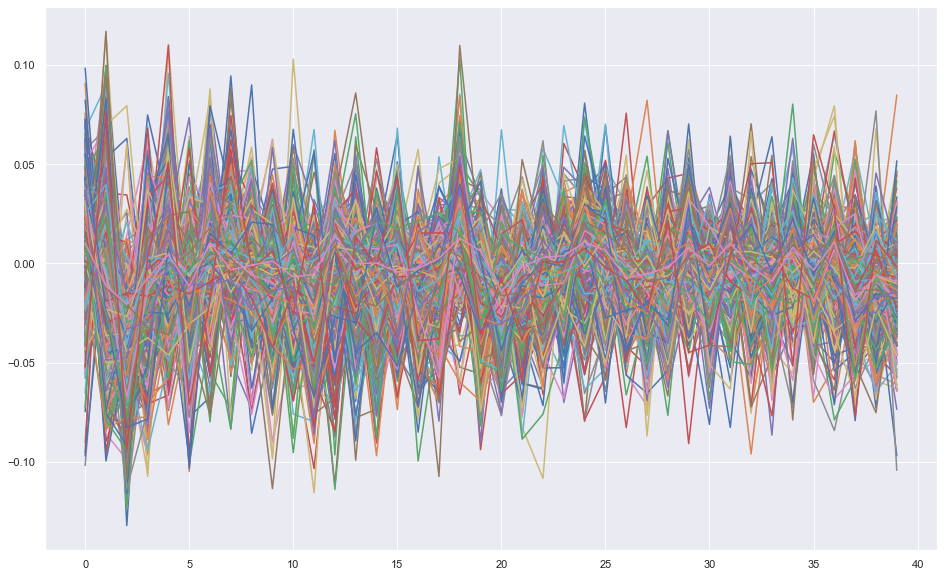

847

In [55]:
import pywt
a = clusters_data_list3[4]
for c in a['SecurityID']:
    try:
        grpah = new_data[new_data['SecurityID']==c].GSpread.pct_change().dropna().values
        plt.plot(grpah)
    except:
        pass
plt.rcParams["figure.figsize"] = (16,10)
plt.show()
len(a)

from sklearn.metrics import silhouette_score
inertias = {}
silhouettes = {}
for k in range(2, 200):
    kmeans = KMeans(init='k-means++', n_init=10, n_clusters=k, max_iter=1000, random_state=42).fit(data_scaled)
    inertias[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouettes[k] = silhouette_score(data_scaled, kmeans.labels_, metric='euclidean')
    

plt.figure();
plt.grid(True);
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");


plt.figure();
plt.grid(True);
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");

In [38]:
data = {}
l = []
a = clusters_data_list3[0]
for c in a['SecurityID']:
    graph = new_data[new_data['SecurityID']==c].GSpread.pct_change().dropna().values
    if len(graph) == 40:
        data[c] = graph
        l.append(c)

In [39]:
df = pd.DataFrame(data,columns=l)

corrMatrix = df.corr()

In [40]:
corrMatrix.head()

1890      1931      2010      2113      2951      3153      5291   \
1890  1.000000  0.404644  0.326397  0.121033  0.130462  0.202413  0.018328   
1931  0.404644  1.000000  0.329391  0.172790  0.307886  0.309269 -0.067384   
2010  0.326397  0.329391  1.000000  0.485379  0.275512 -0.014852  0.216263   
2113  0.121033  0.172790  0.485379  1.000000  0.341011  0.039309  0.651403   
2951  0.130462  0.307886  0.275512  0.341011  1.000000  0.100729  0.311805   

         6097      6149      6654   ...     51969     52096     52395  \
1890  0.133306  0.460624  0.281897  ...  0.296283 -0.024320  0.268182   
1931  0.365030  0.351816  0.262923  ...  0.457857 -0.010497  0.358447   
2010  0.198672  0.368569  0.450232  ...  0.332030  0.037489  0.050298   
2113  0.226929  0.219834  0.125355  ...  0.065235 -0.017737  0.073202   
2951  0.353243  0.326237  0.171922  ...  0.196616  0.255363  0.571906   

         54906     55124     55284     55344     55413     55729     58181  
1890  0.207497  0.463768  0.332787  0.044437  0.008778  0.282625  0.405535  
1931  0.396817  0.505357  0.345371  0.108050  0.356545  0.524961  0.291122  
2010  0.294004  0.328745  0.243251  0.257063  0.342970  0.488109  0.221213  
2113  0.165283  0.175683  0.132902  0.078053 -0.011581  0.164874  0.293140  
2951  0.095559  0.226470  0.211710 -0.120473  0.027267  0.134422  0.058388  

[5 rows x 112 columns]

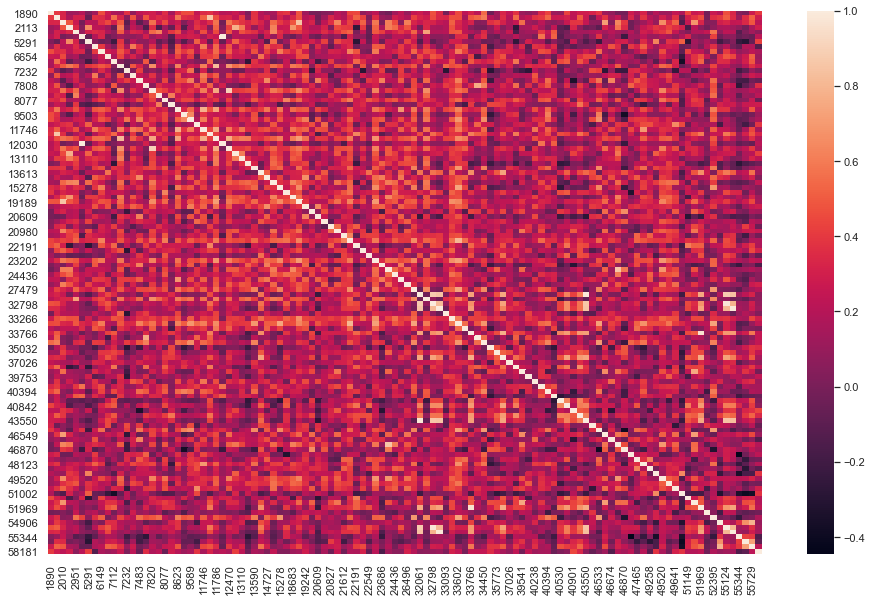

In [41]:
import seaborn as sns; sns.set()
corr = corrMatrix
ax = sns.heatmap(corr)

In [42]:
clusters_data_list3[0]

SecurityID          Sector                              Industry  \
0          1890      Technology  Design, Manufacturing & Distribution   
1          1931      Financials                     Diversified Banks   
2          2010      Technology                              Hardware   
3          2113      Financials                    Financial Services   
4          2951      Financials                    Financial Services   
..          ...             ...                                   ...   
107       55284  Communications  Wireless Telecommunications Services   
108       55344     Real Estate                           Real Estate   
109       55413     Real Estate                           Real Estate   
110       55729     Real Estate                           Real Estate   
111       58181     Real Estate                           Real Estate   

                 Sub_Industry         Seniority  \
0    Electronic Parts Distrib      Sr Unsecured   
1    Diversified Banking Inst      Sr Unsecured   
2                   Computers  1st Lien Secured   
3    Diversified Banking Inst      Sr Unsecured   
4    Diversified Banking Inst      Sr Unsecured   
..                        ...               ...   
107          Cellular Telecom           Secured   
108  Real Estate Oper/Develop      Sr Unsecured   
109  Real Estate Oper/Develop  1st Lien Secured   
110  Real Estate Oper/Develop           Secured   
111  Real Estate Oper/Develop      Sr Unsecured   

                                    Issuedby Country       Rating  \
0                             TECH DATA CORP      US         BBB-   
1                        SOCIETE GENERALE SA      FR         BBB+   
2          DELL INTERNATIONAL LLC / EMC CORP      US         BBB-   
3           UBS GROUP FUNDING SWITZERLAND AG      CH           A-   
4                             MORGAN STANLEY      US         BBB+   
..                                       ...     ...          ...   
107                   OZTEL HOLDINGS SPC LTD      OM  Not Founded   
108              ZHENRO PROPERTIES GROUP LTD      CN           B-   
109                 TIMES CHINA HOLDINGS LTD      CN  Not Founded   
110                          EASY TACTIC LTD      CN  Not Founded   
111  CHENGDU HI-TECH INVESTMENT GROUP CO LTD      CN  Not Founded   

     AmountIssued  Coupon IssueDate     MaturityDate  
0    5.000000e+08   4.950      2017  2027-02-15 0:00  
1    6.000000e+08   4.000      2017  2027-01-12 0:00  
2    3.750000e+09   5.450      2016  2023-06-15 0:00  
3    2.500000e+09   4.125      2015  2025-09-24 0:00  
4    1.000000e+09   7.250      2002  2032-04-01 0:00  
..            ...     ...       ...              ...  
107  9.000000e+08   6.625      2018  2028-04-24 0:00  
108  4.000000e+08  10.500      2018  2020-06-28 0:00  
109  4.500000e+08   7.850      2018  2021-06-04 0:00  
110  2.000000e+08   8.875      2018  2021-09-27 0:00  
111  3.000000e+08   6.280      2018  2021-11-14 0:00  

[112 rows x 12 columns]

In [43]:
group_number =1
final_cluster = pd.DataFrame(columns = ['id','cluster'])
for i in clusters_data_list3:
    temp = pd.DataFrame()
    temp['id'] = i['SecurityID']
    temp['cluster'] = group_number
    final_cluster = final_cluster.append(temp,ignore_index=True)
    group_number += 1

In [44]:
data = pd.read_csv('Landis_tstrend_features.csv')

In [45]:
final_features_data = data.merge(final_cluster,on=['id'],how='left')

In [46]:
final_features_data.to_csv('Landis_tstrend_features_f1.csv')